In [97]:
# predicting antidepressant response in MDD (synthetic data)

In [98]:
# This notebook makes synthetic patient data to predict antidepressant treatment response

In [99]:
# imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns # prettier w/ less effort 

In [100]:
# random seed set  
    # we set a random seed so the random numbers we generate are the same every time
    # important for ML principles of reproducibility 
np.random.seed(42)
# no. of fake patients 
n_samples = 500 
    # 500 is big enough to look real + small enough to run quickly 

In [117]:
# feature grp generation; break into logical chunks 

# --- Demographics ---

# age --> generate 500 random ints b/w 18-75. use random.randint() fn; generate random ints!
    # low = 18
    # high = 75
    # size = 500 (n_samples)
    #dtype = int (age)
         # ~~~ NOTE : high = 76 bc upper bound is EXCLUSIVE 
age = np.random.randint(low =18, high = 76, size=n_samples, dtype = int)


# sex --> how to rep categories as numbers as most ML models can't read text like 'M" or 'F'
    # we can encode categories as ints ----
    # 2 categories: 0 = F, 1 = M)
        # ~~~ NOTE : high = 2 bc upper bound is EXCLUSIVE 
sex = np.random.randint(low = 0, high = 2, size=n_samples, dtype = int)


# --- baseline clincial scores --- 

        # important bc this teaches how to choose realistic + clinically meaningful ranges

# baseline_phq9 --> from 0-27, but picking 5-27 bc unlikely someone w/ score 0 starts treatment
baseline_phq9 = np.random.randint(low = 5, high = 28, size=n_samples, dtype = int)
    # keep in mind, higher severity should lower probability of response ! 

# baseline_gad7
baseline_gad7 = np.random.randint(low = 3, high = 22, size=n_samples, dtype = int)
    # again someone w/ 0 symptoms will NOT be a clinically anxious patient so discard <3

# ep_count --> # of depressive eps in a patient's lifetime 
    # typical 1-5 for most samples. ≥1 to be diagnosed (≠ 0).
ep_count = np.random.randint(low = 1, high = 8, size=n_samples, dtype = int)

# illness_dur_yrs --> how long patient has had depression
    # ~~ NOTE : using float, not int now. 0.5 yrs -> new diagnosis, 20+ yrs -> chronic
illness_dur_yrs = np.random.uniform(low = 0.5, high = 20, size=n_samples)
# we can round to 1 d.p for consiceness using np.round() fn
illness_duration_years = np.round(illness_dur_yrs, 1)



# --- symptoms (neuro-adj) --- ; features used in psych studies, neuromod trials, clinical ML papers
        # good to learn how to generate bounded int scales; appear everywhere in pscyh/neurology datasets

# sleep_disturbance_score --> sleep issues common in depression; 0-10 scale for severity 
sleep_disturbance_score = np.random.randint(low = 0, high = 11, size=n_samples, dtype = int)

# anhedonia_score --> loss of pleasure (0 = no, 10 = severe)
anhedonia_score = np.random.randint(low=0, high=11, size=n_samples, dtype=int)

# cognitive_score --> cog function (memmory, attention) on 0-10 scale; neuro-ish proxy
cognitive_score = np.random.randint(low=0, high=11, size=n_samples, dtype=int)


# ---- treatment type --- ; this introduces CATEGORICAL data gen using np.random.choice()
    # real data has drug classes like SSRI (sertraline), SNRI (venlafaxine), atypical anti-depressants, etc..
# SSRI_A, SSRI_B, SNRI are 3 simple classes we can use 
treatment_types = np.array(["SSRI_A", "SSRI_B", "SNRI"])
                           # we can use a numpy array bc it works nicely w/ vectorised operations
                           # also easy to feed --> np.random.choice()
#now make a random treatment for EACH patient 
treatment_type = np.random.choice(a=treatment_types, size=n_samples)


# ---- response variable ---- ; this is how likely each patient is to respond to their antidepressant based on symptoms
# probability formula --> this is a baseline probabiltiy. 
    # think abt what % of patients respond to antidepressants IRL? usually 40-60% on trial. so pick 60% chance!
base_prob = 0.6 
    # as PHQ-9 increases, ==  lower response probability 
        # e.g, prob -1% for each PHQ-9 point above 10 --> -0.01 * (baseline_phq9 - 10)
    # so PHQ-9 = 10 (no change), PHQ-9 = 20 (reduce prob by 10%), PHQ-9 = 5, (increase prob by 5%)
severity_effect =(baseline_phq9 - 10) * -0.01
    # PHQ-9 > 10 reduces chance, PHQ-9 < 10 increases chance (scalable !)

# now consider past eps; more = harder to treat,,, say ~3% per additional ep (1)
ep_effect = (ep_count - 1) * 0.03 
    # 1 ep = 0 adjustment, 4 ep = -9%, 7ep = -18% (realistically harsh; accurate for recurrent MDD)

# now w/ illness_dur, longer depression = harder to treat,,, say ~2% per yr beyond 2yrs
dur_effect = (illness_dur_yrs - 2) * 0.02
    # 0.5 = slight increase, 2yr = gradual decrease, 10yr = significant decrease

# for treatment effect, SNRIs (in this synthetic world) are more effective (+5%)
treatment_effect = np.where(treatment_type == "SNRI", 0.05, 0.0)
    # so if treatment_type = "SNRI", adds 0.05 . if not, adds 0.00
    # numpy applies this across ALL 500 patients ! 

# now COMBO it all into ONE probability formula ...
prob_response = base_prob + severity_effect + ep_effect + dur_effect + treatment_effect
    # then ensure its b/w 5-95% (so no absurd values)
prob_response = np.clip(prob_response, 0.05, 0.95)

# binary response generation  --> actual 0.1 response label ! 
response = np.random.binomial(1, p=prob_response)
    # now each patient gets assigned 0 or 1 using their OWN probability w/ all factors taken into account 

In [119]:
# combo --> Dataframe (DF)

df = pd.DataFrame({
    "age": age,
    "sex": sex,
    "baseline_phq9": baseline_phq9,
    "baseline_gad7": baseline_gad7,
    "episodes_count": ep_count,
    "illness_duration_years": illness_dur_yrs,
    "sleep_disturbance_score": sleep_disturbance_score,
    "anhedonia_score": anhedonia_score,
    "cognitive_score": cognitive_score,
    "treatment_type": treatment_type,
    "response": response,})
    

In [121]:
# now we can look at the first few rows using df.head() --> confirms dataset looks 'right'
df.head()
# also describe() will show everything looks sane 
df.describe()

,age,sex,baseline_phq9,baseline_gad7,episodes_count,illness_duration_years,sleep_disturbance_score,anhedonia_score,cognitive_score,response
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,46.234000,0.484000,16.296000,12.198000,4.016000,10.119068,5.126000,5.098000,4.978000,0.762000
std,16.398447,0.500244,6.866636,5.410114,1.978781,5.860044,3.191001,3.198258,3.263559,0.426286
min,18.000000,0.000000,5.000000,3.000000,1.000000,0.512237,0.000000,0.000000,0.000000,0.000000
25%,32.750000,0.000000,10.000000,7.000000,2.000000,4.799551,2.000000,2.000000,2.000000,1.000000
50%,46.000000,0.000000,17.000000,12.000000,4.000000,10.080794,5.000000,5.000000,5.000000,1.000000
75%,60.000000,1.000000,22.000000,17.000000,6.000000,15.165127,8.000000,8.000000,8.000000,1.000000
max,75.000000,1.000000,27.000000,21.000000,7.000000,19.967216,10.000000,10.000000,10.000000,1.000000


In [123]:
# now we can check for missing values 
df.isnull().sum()
    # everything should be 0 

age                        0
sex                        0
baseline_phq9              0
baseline_gad7              0
episodes_count             0
illness_duration_years     0
sleep_disturbance_score    0
anhedonia_score            0
cognitive_score            0
treatment_type             0
response                   0
dtype: int64

In [125]:
# now we can check distributiosn of key features; we have no plots yet so these will be numerical summaries
# tell us:
    # are severity scores evenly spread
    # are treatment groups balanced
    # is response approx 40-60%
    # are episode counts skewed toward low numbers 
    # do symptoms span 0-10 in a healthy distribution 

# these are impotrant sanity checks before modelling 

df['baseline_phq9'].value_counts().sort_index()
df['baseline_gad7'].value_counts().sort_index()
df['episodes_count'].value_counts().sort_index()
df['treatment_type'].value_counts()
df['response'].value_counts()

# we use value_counts() to say 'show me # of times each value appears'; counts the freq of each category or int !
    # useful to check distribution, skew, mode, etc... 
    # by default value_counts() sorts by frequency (not number); sorts by number MOST common, not in numeric order.

# also use sort_index() to say 'sort these counts by the ACTUAL numeric value' --> sorts by frequency, not number
    # we can use this to get the ascneding numeric order; much easier to read ! 
    # helps us understand how the values are distributed across the scale 

# so we use value_counts() and sort_index() together:
    # VC --> tells us how common each value is 
    # SI --> lets us read this in a natural order

response
1    381
0    119
Name: count, dtype: int64

In [127]:
#now we can also check the average PHQ-9 for responders vs non-responders:
    # responders have lower PHQ-9, non-responders have higher
df.groupby("response")["baseline_phq9"].mean() 

response
0    18.142857
1    15.719160
Name: baseline_phq9, dtype: float64

In [129]:
# results are good --> non-responders (0) = ~16, and responders (1) = ~13/14
    # makes sense in real-world sceanrio as higher baseline severity = poorer response, and 
    # milder/moderate baselin = better response 

Text(0, 0.5, 'Count')

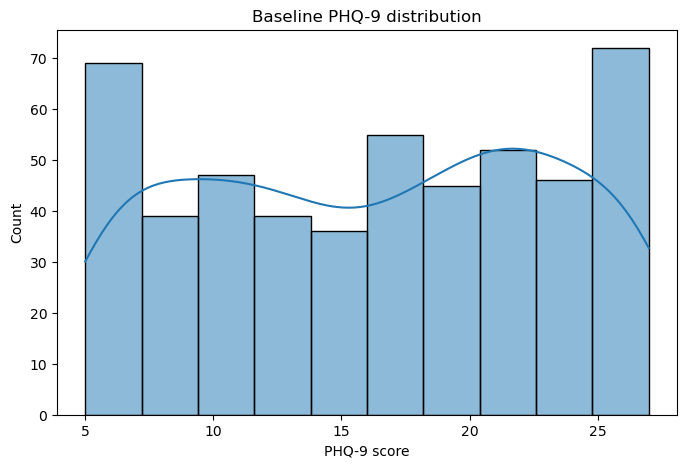

In [131]:
# now to plot the distribution of baseline PHQ-9; helps us see how severity is spread 
# as PHQ-9 is a numeric feature, we want to use a histogram 
    # answers 'how often does each PHQ-9 score appear?'

# we can make a figure; blank canvas first with figsize a bit bigger (w=8, h=5)
plt.figure(figsize=(8,5))
sns.histplot(x=df["baseline_phq9"], kde=True)
 # use x arg as column values to take from 
# use kde=True to add bars (raw counts) and curve (density estimate; intuitive!) 
    # curve reps distribution shape 

# now we can add label axes + title like a real EDA plot 
plt.title("Baseline PHQ-9 distribution")
plt.xlabel("PHQ-9 score")
plt.ylabel("Count")



Text(0, 0.5, 'Count')

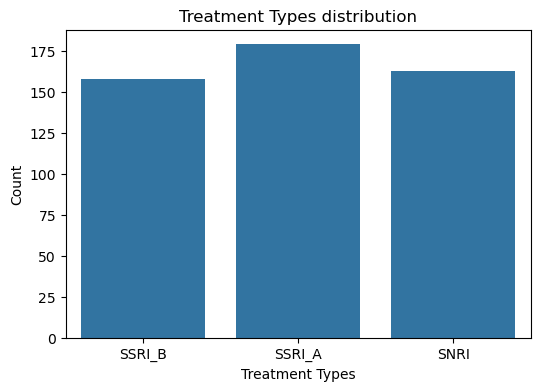

In [133]:
# now we can focus on a categorical variable ! Treatment type distribution 
# we will make use of a bar chart; so from histplot --> countplot

plt.figure(figsize=(6,4))
#now countplot() will say == "how many times does each category appear?" 
sns.countplot(x=df['treatment_type']) #x = pls count categories in this column + make bars for them

# now we can add title, axis labels ... 
plt.title("Treatment Types distribution")
plt.xlabel("Treatment Types")
plt.ylabel("Count")

# as we can see, SNRI is a bit above (~165)

Text(0, 0.5, 'Count')

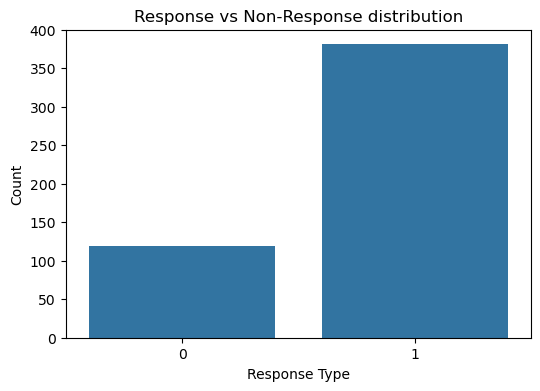

In [135]:
# now for response vs non-response distribution ; another categorical so repeat 
plt.figure(figsize=(6,4))
# now countplot = 'how many times does each responder type appear?
sns.countplot(x=df['response'])

# again labels 
plt.title("Response vs Non-Response distribution")
plt.xlabel("Response Type")
plt.ylabel("Count") 


<Axes: xlabel='response', ylabel='baseline_phq9'>

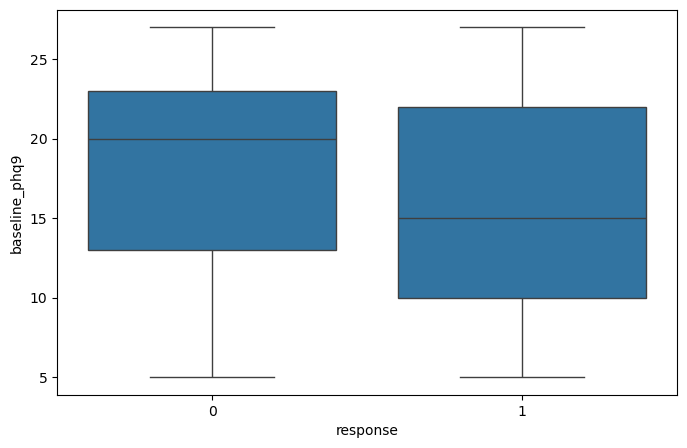

In [137]:
# now we can use a boxplot for Baseline PHQ-9 by Treatment Response
    # x = category, y = numeric value 
# this answers VISUALLY: Do responders have diff PHQ-9 scores than non-responders?
plt.figure(figsize=(8,5))
# now boxplot is perfecto compare: x-axis (category; 0 vs 1, non-r vs r) and y-axis (numeric feature; PHQ-9)

sns.boxplot(x='response', y='baseline_phq9', data=df) 
    # we pass column names as strs NOT df[..] bc seaborn handles them internally 

# we can see 2 boxes --> response = 0 (non-R) and response = 1 (R)
    # each box shows:
        # median PHQ-9
        # interquartile range (middle 50%) 
        # whiskers + potential outliers 
    # should expect non-R to have HIGHER baseline PHQ-9 (more severe)
    # responders to have lower baseline PHQ-9 

In [139]:
# at this point we have 2 seaborn styles used :

# 1) passing a Series directly (counplots)
        #sns.countplot(x=df['response'])
            # here we give seaborn the ACTUAL series (df['response'])
            # No data= arg is needed ... x IS the data 

# 2) using a DF + column names (boxplot)
        #sns.boxplot(x='response', y='baseline_phq9', data=df) 
            # x = response, y=baseline_phq9 --> 'these are column names inside that DF' ..
        # so X + Y are STRINGS, NOT series ... 

Text(0, 0.5, 'Baseline PHQ-9 Score')

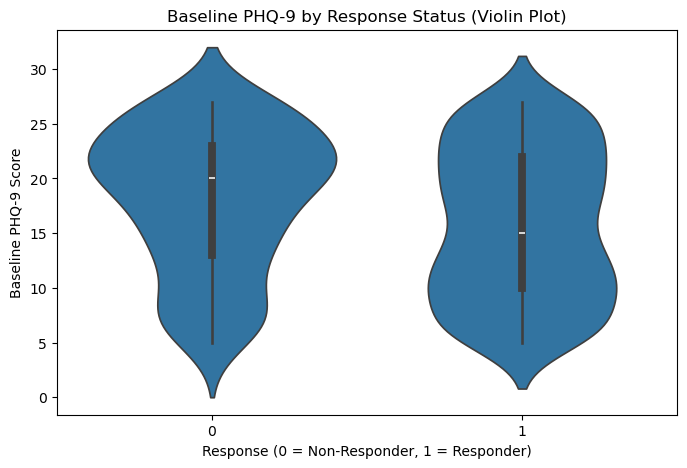

In [153]:
# finally we can use the violin plot (PHQ-9) by resposne group !
    # this is a smoother, prettier ver of boxplot basically + shows distribution shape 
plt.figure(figsize=(8,5))
sns.violinplot(x='response', y='baseline_phq9', data=df)
# now we add labels as per 
plt.title("Baseline PHQ-9 by Response Status (Violin Plot)")
plt.xlabel("Response (0 = Non-Responder, 1 = Responder)")
plt.ylabel("Baseline PHQ-9 Score")